In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
from matplotlib import pyplot as plt
from scipy.stats import ttest_rel, ttest_1samp
from statsmodels.stats.multitest import multipletests

### These are from the week BEFORE the ICLR paper submission

In [ ]:
# ============== This cell contains code for: ========================
# === Figure 1 ===
# === Statistical significance – base vs booksum – 20vs20 accuracy ===

def extract_brain_score(pkl_path):
    loaded = pickle.load(open(pkl_path, 'rb'))          # (4, ~27905)
    mean_subj_acc_across_folds = loaded.mean(0)         # (~27905,)
    mean_overall = mean_subj_acc_across_folds.mean(0)   # scalar

    return mean_overall

nlp_model_list = []
nlp_model_list += ['bart-base', 'bart-booksum']
nlp_model_list += ['led-base', 'led-booksum']
nlp_model_list += ['bigbird-base', 'bigbird-booksum']
nlp_model_list += ['long-t5-base', 'long-t5-booksum']
nlp_model_list = list( set(nlp_model_list) )
nlp_model_list.sort()

seq_len_list = [20, 100, 200, 300, 400, 500, 700, 1000]
layer_list = [1, 2, 4, 6, 8, 10, 11, 12]
subject_list = ['F', 'H', 'I', 'J', 'K', 'L', 'M', 'N']

# Collect results into lists for both base and booksum
base_results = []
booksum_results = []

for nlp_model in nlp_model_list:
    base_or_booksum = 'booksum' if '-booksum' in nlp_model else 'base'
    for layer in layer_list:
        for seq_len in seq_len_list:

            num_subjects = 0
            for subject in subject_list:
                pkl_path = f'3-eval-results/{nlp_model}/predict_{subject}_with_{nlp_model}_layer_{layer}_len_{seq_len}_accs.pkl'
                if not os.path.isfile(pkl_path):
                    continue
                acc = extract_brain_score(pkl_path)
                
                if '-booksum' in nlp_model:
                    booksum_results.append(acc)
                elif '-base' in nlp_model:
                    base_results.append(acc)
                num_subjects += 1
                    
            # If no data was found, just skip and do not add
            if num_subjects < len(subject_list):
                print(f'@@@ Incomplete: {nlp_model}-layer{layer}-seq{seq_len}, # subjects = {num_subjects} ===')
                continue
            
# Compute statistical significance
print('Length of base results list:', len(base_results))
print('Length of base results list:', len(booksum_results))
ttest_rel(base_results, booksum_results, alternative='less')

In [ ]:
# ============== This cell contains code for: ========================
# === Figure 2, Left ===
# === Statistical significance – base vs booksum - Language modeling ability ===

def extract_results(pkl_path):
    loaded = pickle.load(open(pkl_path, 'rb'))
    trained_weights = loaded['trained_weights']
    perplexity_list = loaded['perplexity_list']
    loss_list = [ np.log(x) for x in perplexity_list ]

    decimal_places = 2
    mean_perplexity = round( sum(perplexity_list) / len(perplexity_list), decimal_places)
    mean_loss = round( sum(loss_list) / len(loss_list), decimal_places)
    perplexity_list = [ round(p,decimal_places) for p in perplexity_list ]
    loss_list = [ round(loss,decimal_places) for loss in loss_list ]

    return trained_weights, mean_perplexity, perplexity_list, mean_loss, loss_list

# === Change these variables ===
# Change NLP models to analyze
nlp_model_list = []
# nlp_model_list += ['bart-base', 'bart-booksum']
# nlp_model_list += ['long-t5-base', 'long-t5-booksum']
# nlp_model_list += ['led-base', 'led-booksum']
nlp_model_list += ['bigbird-base', 'bigbird-booksum']
nlp_model_list = list( set(nlp_model_list) )
nlp_model_list.sort()

# Change which set of experiments to analyze
expt_name = 'freeze_early5'

# Collect results into lists for both base and booksum
base_results = []
booksum_results = []

for nlp_model in nlp_model_list:
    pkl_path = f'4-perplexity-results/{expt_name}/{nlp_model}/perplexity.pkl'
    if not os.path.isfile(pkl_path):
        continue
    
    trained_weights, mean_perplexity, perplexity_list, mean_loss, loss_list = extract_results(pkl_path)
    print(f'{nlp_model}: {loss_list}')
    for cv_loss in loss_list:
        if '-booksum' in nlp_model:
            booksum_results.append(cv_loss)
        elif '-base' in nlp_model:
            base_results.append(cv_loss)

# Compute statistical significance
print('Length of base results list:', len(base_results))
print('Length of base results list:', len(booksum_results))
ttest_rel(base_results, booksum_results, alternative='less')

In [ ]:
# ============== This cell contains code for: ========================
# === Figure 2, Right ===
# === Statistical significance – base vs booksum - for each brain ROI ===

roi_label_list = ['all', 'PostTemp', 'AntTemp', 'AngularG', 'IFG', 'MFG', 'IFGorb', 'pCingulate', 'dmpfc', 'Non-language']

def extract_brain_scores_per_roi(brain_score_pkl_path, subject):
    brain_score_loaded = pickle.load(open(brain_score_pkl_path, 'rb'))          # (4, ~27905)
    brain_score_voxels_ALL = brain_score_loaded.mean(0)                         # (~27905,)
    HP_subj_roi_inds_loaded = np.load('./data/HP_subj_roi_inds.npy', allow_pickle=True)

    brain_scores_per_roi = np.empty([len(roi_label_list)])                      # will be: [58.83, 59.21, ...]
    for ind, roi_label in enumerate(roi_label_list):
        # RoI mask for voxels outside language region is simply the logical NOT of the region 'all'
        if roi_label == 'Non-language':
            region_all_mask = HP_subj_roi_inds_loaded.item()[subject]['all']
            roi_mask = np.logical_not(region_all_mask)
        else:
            roi_mask = HP_subj_roi_inds_loaded.item()[subject][roi_label]       # (~27905,) => [True,False,False,True,...]

        brain_score_voxels_roi = brain_score_voxels_ALL[roi_mask]               # (~783,)
        brain_score_voxels_roi_mean = brain_score_voxels_roi.mean()             # scalar
        brain_scores_per_roi[ind] = round(100*brain_score_voxels_roi_mean, 2)
    return brain_scores_per_roi                                                 # (10,)

# === Change these variables ===
nlp_model_list = []
# nlp_model_list += ['led-base', 'led-booksum']
nlp_model_list += ['long-t5-base', 'long-t5-booksum']
# nlp_model_list += ['bigbird-base', 'bigbird-booksum']
# nlp_model_list += ['bart-base', 'bart-booksum']
# === Automatically set ===
nlp_model_list = list( set(nlp_model_list) )
nlp_model_list.sort()

seq_len_list = [20, 100, 200, 300, 400, 500]
seq_len_list += [700, 1000]
layer_list = [1, 2, 4, 6, 8, 10, 11, 12]
subject_list = ['F', 'H', 'I', 'J', 'K', 'L', 'M', 'N']

# Collect results into lists for both base and booksum
base_results = [ [] for _ in range(len(roi_label_list)) ]    # Create 1 list for each brain ROI
booksum_results = [ [] for _ in range(len(roi_label_list)) ] # Create 1 list for each brain ROI
incomplete_list = [] # store names of configurations which have incomplete results

for nlp_model in nlp_model_list:
    for layer in layer_list:
        for seq_len in seq_len_list:
            
            brain_scores_per_roi_multiple_subjects = []
            for subject in subject_list:
                pkl_path = f'3-eval-results/{nlp_model}/predict_{subject}_with_{nlp_model}_layer_{layer}_len_{seq_len}_accs.pkl'
                if not os.path.isfile(pkl_path):
                    continue
                
                brain_scores_per_roi = extract_brain_scores_per_roi(pkl_path, subject)
                for roi_ind in range(len(brain_scores_per_roi)):
                    if '-booksum' in nlp_model:
                        booksum_results[roi_ind].append(brain_scores_per_roi[roi_ind])
                    elif '-base' in nlp_model:
                        base_results[roi_ind].append(brain_scores_per_roi[roi_ind])
                    brain_scores_per_roi_multiple_subjects.append(brain_scores_per_roi[roi_ind])
                
            # If # of subjects is less than the subjects we want, data is not complete, do NOT export
            if len(brain_scores_per_roi_multiple_subjects) < len(subject_list):
                incomplete_list.append(f'{nlp_model}-layer{layer}-seq{seq_len}-#subj={len(brain_scores_per_roi_multiple_subjects)}')

print(f'Incomplete list: {incomplete_list}')
p_value_list = []
# Compute statistical significance
for roi_ind, roi_label in enumerate(roi_label_list):
    base_results_for_roi = base_results[roi_ind]
    booksum_results_for_roi = booksum_results[roi_ind]
    statistic, pvalue = ttest_rel(base_results_for_roi, booksum_results_for_roi, alternative='less')
    print(f'pvalue for {roi_label}: {pvalue}')
    p_value_list.append(pvalue)
print('p_value_list:', p_value_list)

In [6]:
# ============== This cell contains code for: ========================
# === Figure 3b, Right ===
# === Statistical significance – base vs booksum - for each discourse feature ===

def get_pearson_from_saved_pkl(pkl_path):
    # print('get_pearson_from_saved_pkl:', pkl_path)
    loaded = pickle.load(open(pkl_path, 'rb'))
    return loaded['mean_pearson_across_subjects'], loaded['pearson_dict']

# === Change these variables ===
nlp_model_list = []
nlp_model_list += ['bart-base', 'bart-booksum']
nlp_model_list += ['led-base', 'led-booksum']
nlp_model_list += ['bigbird-base', 'bigbird-booksum']
nlp_model_list += ['long-t5-base', 'long-t5-booksum']
nlp_model_list = list( set(nlp_model_list) )
nlp_model_list.sort()

expt_setting_list = ['Characters', 'Emotion', 'Motion']
# expt_setting_list +=  ['Non-discourse', 'Full']

seq_len_list = [20, 100, 200, 500, 700, 1000]
# seq_len_list = [20, 100, 200, 500]
# layer_list = [6, 7, 8, 9, 10, 11, 12]
layer_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
subject_list = ['F', 'H', 'I', 'J', 'K', 'L', 'M', 'N']

p_value_list = []
for expt_setting in expt_setting_list:
    
    # Collect results into lists for both base and booksum
    base_results = []
    booksum_results = [] 
    incomplete_list = [] # store names of configurations which have incomplete results
    
    for nlp_model in nlp_model_list:
        for layer in layer_list:
            for seq_len in seq_len_list:
                # If final Pearson correlation results have been computed and saved, just load it
                pearson_saved_path = f'7-pearson-saved/{expt_setting}/{nlp_model}/pearson_{nlp_model}_layer_{layer}_len_{seq_len}.pkl'
                if os.path.isfile(pearson_saved_path):
                    mean_pearson_across_subjects, pearson_dict = get_pearson_from_saved_pkl(pearson_saved_path)
                    
                    for subject, pearson_score in pearson_dict.items():
                        if '-booksum' in nlp_model:
                            booksum_results.append(pearson_score)
                        elif '-base' in nlp_model:
                            base_results.append(pearson_score)
                
                else:
                    incomplete_list.append(f'{nlp_model}_layer_{layer}_len_{seq_len}')

    # Compute statistical significance
    # print(f'Incomplete list: {len(incomplete_list)}')
    # # print(f'Incomplete list: {incomplete_list}')
    # print('Length of base results list:', len(base_results))
    # print('Length of booksum results list:', len(booksum_results))
    statistic, pvalue = ttest_rel(base_results, booksum_results, alternative='less')
    print(f'pvalue for {expt_setting}: {pvalue}')
    p_value_list.append(pvalue)
print('p_value_list:', p_value_list)

pvalue for Characters: 3.129971193269186e-59
pvalue for Emotion: 5.365315263165712e-23
pvalue for Motion: 4.205432387802319e-45
pvalue for Non-discourse: 5.245986953788277e-24
pvalue for Full: 1.4778366550942308e-18
p_value_list: [3.129971193269186e-59, 5.365315263165712e-23, 4.205432387802319e-45, 5.245986953788277e-24, 1.4778366550942308e-18]


In [ ]:
[3.129971193269186e-59, 5.365315263165712e-23, 4.205432387802319e-45, 5.245986953788277e-24, 1.4778366550942308e-18]
[1.7628382906813157e-22, 2.0285215953713987e-11, 4.443630878955692e-13, 4.951163687163465e-09, 1.8870589459346321e-07]
[8.523219646357165e-11, 0.001090135626055918, 2.9896945223893507e-06, 0.12262198082552087, 0.006347289095557193]
[3.8443839127189954e-20, 9.157825752977463e-20, 1.9076513557159456e-15, 7.767172958116534e-13, 1.3567466489270657e-08]
[3.447617911037758e-16, 0.290215359345456, 2.806972457819754e-22, 1.0137993226386827e-11, 3.7643068243115543e-06]


In [17]:
# ============== This cell contains code for: ========================
# === Figure 3b, Right (* but show that improvements for Character are greater than others)===
# === Statistical significance – booksum minus base - for each discourse feature ===

# Read the dataframe already generated
df_orig = pd.read_csv('0-logs/figures_paper/fig_3b/df_pearson_scores_expanded.csv')

df_base = df_orig.loc[df_orig['base_or_booksum'] == 'base']                # Get rows for base, and also booksum models
df_booksum = df_orig.loc[df_orig['base_or_booksum'] == 'booksum']

# Uncomment this to filter out only for 1 model at a time
model_type = 'led'
df_base = df_base.loc[df_base['model_type'] == model_type]
df_booksum = df_booksum.loc[df_booksum['model_type'] == model_type]

columns_to_check_match = ['expt_setting', 'model_type', 'layer', 'seq_len', 'subject']
df_base = df_base.sort_values(columns_to_check_match).reset_index()
df_booksum = df_booksum.sort_values(columns_to_check_match).reset_index()
assert df_booksum[columns_to_check_match].equals(df_base[columns_to_check_match])   # Ensure that the rows for base and booksum dataframes are correctly aligned
df_booksum_minus_base = df_booksum.copy()[['expt_setting']]
df_booksum_minus_base['pearson_difference'] = df_booksum['subj_pearson'] - df_base['subj_pearson']          # Compute booksum - base, for mean pearson, grouped by ['expt_setting', 'roi_label']

discourse_feature_list = ['Characters', 'Emotion', 'Motion', 'Non-discourse', 'Full']
discourse_features_diff_list = []
for discourse_feature in discourse_feature_list:
    tmp = df_booksum_minus_base.loc[df_booksum_minus_base['expt_setting'] == discourse_feature]
    discourse_features_diff_list.append( list(tmp['pearson_difference']) )

# List of size 5, each item is a list of 154 items
len(discourse_features_diff_list[0])

p_value_list = []
character_improvement_list = discourse_features_diff_list[0]
for i in range(1,5):
    discourse_feature_to_compare_improvement_list = discourse_features_diff_list[i]
    # print(f'len: {len(character_improvement_list)}, {len(discourse_feature_to_compare_improvement_list)}')
    statistic, pvalue = ttest_rel(character_improvement_list, discourse_feature_to_compare_improvement_list, alternative='greater')
    print(f'pvalue for improvements: Character greater than {discourse_feature_list[i]}: {pvalue}')
    p_value_list.append(pvalue)
print('p_value_list:', p_value_list)

pvalue for improvements: Character greater than Emotion: 8.064993350937608e-05
pvalue for improvements: Character greater than Motion: 0.0030223810145947544
pvalue for improvements: Character greater than Non-discourse: 5.171531223346712e-05
pvalue for improvements: Character greater than Full: 0.0033619187392714234
p_value_list: [8.064993350937608e-05, 0.0030223810145947544, 5.171531223346712e-05, 0.0033619187392714234]


In [ ]:
[1.245823231378268e-13, 4.018805619146466e-06, 0.004844192829418054, 0.0001435464853155536]
[0.0003868316828374528, 0.000671671985929747, 0.2456649849595065, 0.03751517145589955]
[8.064993350937608e-05, 0.0030223810145947544, 5.171531223346712e-05, 0.0033619187392714234]
[0.2619840419135966, 0.0038222133899118876, 0.23203376024298927, 0.06216562737441828]
[4.577648585584656e-13, 0.3502699436137137, 0.6905993070108212, 0.11835272434575929]

In [ ]:
# ============== This cell contains code for: ========================
# === Figure 4 ===
# === Identify brain voxels where booksum versus base is statistically significant ===

out_sig_voxel_dir = '9-pearson-voxels-for-brain-plot/significant_voxel_indicator'

np.random.seed(42)  # Set random seed

from scipy.stats import zscore
def pearson_corr(X,Y):
    return np.mean(zscore(X)*zscore(Y),0)

def extract_all_voxels_pearson(pred_path, discourse_feature):
    loaded = np.load(pred_path, allow_pickle=True)
    preds_t_per_feat = loaded.item()['preds_t']                             # (1191, ~27905)
    test_t_per_feat = loaded.item()['test_t']
    
    TR_one_hot_pkl_path = f'./data/TR_one_hot_for_features/{discourse_feature}.pkl'
    TR_one_hot = pickle.load(open(TR_one_hot_pkl_path, 'rb'))
    TR_indices = np.where(TR_one_hot==1)[0]                                 # List of TR indices: [10, 13,...]
    TR_indices = np.random.choice(TR_indices, size=162, replace=False)      # Randomly select 162 TR indices, with set seed
    TR_indices = np.sort(TR_indices)
    
    preds_t_per_feat = preds_t_per_feat[TR_indices, :]                      # Extract from only the desired TRs
    test_t_per_feat =  test_t_per_feat[TR_indices, :]

    return pearson_corr(preds_t_per_feat, test_t_per_feat)                  # (~27905,)

# === Change these variables ===
nlp_model_list = []
nlp_model_list += ['bart-base', 'bart-booksum']
nlp_model_list += ['led-base', 'led-booksum']
nlp_model_list += ['bigbird-base', 'bigbird-booksum']
nlp_model_list += ['long-t5-base', 'long-t5-booksum']
nlp_model_list = list( set(nlp_model_list) )
nlp_model_list.sort()

seq_len_list = [20, 100, 200, 500]
seq_len_list += [700, 1000]
layer_list = [6, 7, 8, 9, 10, 11, 12]
subject_list = ['F', 'H', 'I', 'J', 'K', 'L', 'M', 'N']

discourse_feature_list = ['Characters', 'Full']

for discourse_feature in discourse_feature_list:
    for subject in subject_list:
        print(f'--- Entered: {discourse_feature}, {subject} ---')
        base_models_pearson_voxels_list = []
        booksum_models_pearson_voxels_list = []
        
        for nlp_model in nlp_model_list:
            if nlp_model.endswith('-booksum'):
                base_or_booksum_voxels_list_to_append = booksum_models_pearson_voxels_list
            else:
                base_or_booksum_voxels_list_to_append = base_models_pearson_voxels_list

            for layer in layer_list:
                for seq_len in seq_len_list:
                    pred_path = f'2-encoding_predictions/{nlp_model}/predict_{subject}_with_{nlp_model}_layer_{layer}_len_{seq_len}.npy'
                    if not os.path.isfile(pred_path):
                        print(f'@@@ Prediction file not found: subject_{subject}_{nlp_model}_layer_{layer}_len_{seq_len}')
                        continue
                    
                    all_voxels_pearson = extract_all_voxels_pearson(pred_path, discourse_feature)
                    base_or_booksum_voxels_list_to_append.append(all_voxels_pearson)
        
        base_pearson_voxels_stacked = np.vstack(base_models_pearson_voxels_list)        # (xx, ~27905), xx is # of models*layers*...
        booksum_pearson_voxels_stacked = np.vstack(booksum_models_pearson_voxels_list)
        
        n_voxels = base_pearson_voxels_stacked.shape[1]
        voxels_significant_indicator_list = []
        for voxel_num in range(n_voxels):
            base_pearson_voxels = list( base_pearson_voxels_stacked[:, voxel_num] )
            booksum_pearson_voxels = list( booksum_pearson_voxels_stacked[:, voxel_num] )
            
            statistic, pvalue = ttest_rel(base_pearson_voxels, booksum_pearson_voxels, alternative='less')
            voxels_significant_indicator_list.append( pvalue < 0.05 )
        
        # Save the results for significant voxels
        print(f'# significant voxels for {discourse_feature}_{subject}: {len( [x for x in voxels_significant_indicator_list if x] )}')
        sig_voxel_path = os.path.join(out_sig_voxel_dir, f'{discourse_feature}_{subject}.pkl')
        with open(sig_voxel_path, 'wb') as handle:
            pickle.dump(voxels_significant_indicator_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# ============== This cell contains code for: ========================
# === Figure 4 ===
# === Identify brain voxels where booksum is significantly greater than 0 ===

out_sig_voxel_dir = '9-pearson-voxels-for-brain-plot/significant_voxel_indicator'

np.random.seed(42)  # Set random seed

from scipy.stats import zscore
def pearson_corr(X,Y):
    return np.mean(zscore(X)*zscore(Y),0)

def extract_all_voxels_pearson(pred_path, discourse_feature):
    loaded = np.load(pred_path, allow_pickle=True)
    preds_t_per_feat = loaded.item()['preds_t']                             # (1191, ~27905)
    test_t_per_feat = loaded.item()['test_t']
    
    TR_one_hot_pkl_path = f'./data/TR_one_hot_for_features/{discourse_feature}.pkl'
    TR_one_hot = pickle.load(open(TR_one_hot_pkl_path, 'rb'))
    TR_indices = np.where(TR_one_hot==1)[0]                                 # List of TR indices: [10, 13,...]
    TR_indices = np.random.choice(TR_indices, size=162, replace=False)      # Randomly select 162 TR indices, with set seed
    TR_indices = np.sort(TR_indices)
    
    preds_t_per_feat = preds_t_per_feat[TR_indices, :]                      # Extract from only the desired TRs
    test_t_per_feat =  test_t_per_feat[TR_indices, :]

    return pearson_corr(preds_t_per_feat, test_t_per_feat)                  # (~27905,)

# === Change these variables ===
nlp_model_list = []
nlp_model_list += ['led-booksum', 'long-t5-booksum', 'bigbird-booksum', 'bart-booksum']
nlp_model_list = list( set(nlp_model_list) )
nlp_model_list.sort()

seq_len_list = [20]
layer_list = [6, 12]
subject_list = ['F', 'N']

# seq_len_list = [20, 100, 200, 500]
# seq_len_list += [700, 1000]
# layer_list = [6, 7, 8, 9, 10, 11, 12]
# subject_list = ['F', 'H', 'I', 'J', 'K', 'L', 'M', 'N']

discourse_feature_list = ['Characters', 'Full']

for discourse_feature in discourse_feature_list:
    for subject in subject_list:
        print(f'--- Entered: {discourse_feature}, {subject} ---')
        booksum_models_pearson_voxels_list = []
        for nlp_model in nlp_model_list:
            for layer in layer_list:
                for seq_len in seq_len_list:
                    pred_path = f'2-encoding_predictions/{nlp_model}/predict_{subject}_with_{nlp_model}_layer_{layer}_len_{seq_len}.npy'
                    if not os.path.isfile(pred_path):
                        print(f'@@@ Prediction file not found: subject_{subject}_{nlp_model}_layer_{layer}_len_{seq_len}')
                        continue
                    
                    all_voxels_pearson = extract_all_voxels_pearson(pred_path, discourse_feature)
                    booksum_models_pearson_voxels_list.append(all_voxels_pearson)
        
        booksum_pearson_voxels_stacked = np.vstack(booksum_models_pearson_voxels_list)
        
        n_voxels = booksum_pearson_voxels_stacked.shape[1]
        voxels_significant_indicator_list = []
        for voxel_num in range(n_voxels):
            booksum_pearson_voxels = list( booksum_pearson_voxels_stacked[:, voxel_num] )
            
            statistic, pvalue = ttest_1samp(booksum_pearson_voxels, 0.0, alternative='greater')
            voxels_significant_indicator_list.append( pvalue < 0.05 )
        
        # Save the results for significant voxels
        print(f'# significant voxels for {discourse_feature}_{subject}: {len( [x for x in voxels_significant_indicator_list if x] )}')
        sig_voxel_path = os.path.join(out_sig_voxel_dir, 'booksum', f'{discourse_feature}_{subject}.pkl')
        with open(sig_voxel_path, 'wb') as handle:
            pickle.dump(voxels_significant_indicator_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# === Given Pearson values for brain voxels, only keep those where significant ===
all_voxels_dir = '9-pearson-voxels-for-brain-plot/all_voxels'
only_sig_voxels_dir = '9-pearson-voxels-for-brain-plot/only_significant'
sig_voxel_indicator_dir = '9-pearson-voxels-for-brain-plot/significant_voxel_indicator'
subject_list = ['F', 'H', 'I', 'J', 'K', 'L', 'M', 'N']

for ttest_alternative in ['less', 'two-sided']:
    for discourse_feature in ['Characters', 'Full']:
        
        output_dir = os.path.join(only_sig_voxels_dir, ttest_alternative, discourse_feature)
        os.makedirs(output_dir, exist_ok=True)
        
        for subject in subject_list:
            print(f'=== {ttest_alternative}_{discourse_feature}_{subject}===')
            # Get Pearson values for all voxels
            all_voxels_pkl_path = os.path.join(all_voxels_dir, discourse_feature, f'pearson_voxels_{discourse_feature}_{subject}.pkl')
            all_voxels_dict = pickle.load(open(all_voxels_pkl_path, 'rb'))
            all_voxels_booksum_minus_base_pearson = all_voxels_dict['booksum_minus_base_pearson_voxels']    # list of ~27905
            all_voxels_booksum = all_voxels_dict['booksum_pearson_voxels']                                  # list of ~27905
            
            n_voxels = len(all_voxels_booksum)
            
            # Booksum minus Base -- identify which voxels are significant (already done earlier and saved in pickle)
            sig_voxel_indicator_list_pkl_path = os.path.join(sig_voxel_indicator_dir, 'booksum_minus_base', 
                                                             ttest_alternative, f'{discourse_feature}_{subject}.pkl')
            sig_voxel_indicator_list = pickle.load(open(sig_voxel_indicator_list_pkl_path, 'rb'))
            print('# sig voxels for booksum minus base:', len([x for x in sig_voxel_indicator_list if x]))

            sig_voxels_booksum_minus_base_pearson = []
            for voxel_ind in range(n_voxels):
                if sig_voxel_indicator_list[voxel_ind]:
                    sig_voxels_booksum_minus_base_pearson.append(all_voxels_booksum_minus_base_pearson[voxel_ind])
                else:
                    sig_voxels_booksum_minus_base_pearson.append(0)
                    
            # Booksum -- identify which voxels are significantly greater than 0 (already done earlier and saved in pickle)
            sig_voxel_indicator_list_pkl_path = os.path.join(sig_voxel_indicator_dir, 'booksum', 
                                                             f'{discourse_feature}_{subject}.pkl')
            sig_voxel_indicator_list = pickle.load(open(sig_voxel_indicator_list_pkl_path, 'rb'))
            print('# sig voxels for booksum:', len([x for x in sig_voxel_indicator_list if x]))

            sig_voxels_booksum_pearson = []
            for voxel_ind in range(n_voxels):
                if sig_voxel_indicator_list[voxel_ind]:
                    sig_voxels_booksum_pearson.append(all_voxels_booksum[voxel_ind])
                else:
                    sig_voxels_booksum_pearson.append(0)

            sig_voxels_dict = all_voxels_dict
            sig_voxels_dict['booksum_minus_base_pearson_voxels'] = sig_voxels_booksum_minus_base_pearson
            sig_voxels_dict['booksum_pearson_voxels'] = sig_voxels_booksum_pearson
            sig_voxels_pkl_path = os.path.join(output_dir, f'pearson_voxels_{discourse_feature}_{subject}.pkl')
            with open(sig_voxels_pkl_path, 'wb') as handle:
                pickle.dump(sig_voxels_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
tst_pkl_path = '9-pearson-voxels-for-brain-plot/only_significant/Characters/pearson_voxels_Characters_I.pkl'
tst_voxels_dict = pickle.load(open(tst_pkl_path, 'rb'))
tst_voxels_dict

In [ ]:
tst_voxel_indicator_pkl_path = '9-pearson-voxels-for-brain-plot/significant_voxel_indicator/less/Characters_I.pkl'
tst_voxel_indicator = pickle.load(open(tst_voxel_indicator_pkl_path, 'rb'))
len([x for x in tst_voxel_indicator if x])

### These are with false discovery rate correction + individually for NLP models, layers & sequence lengths

In [3]:
from matplotlib.colors import LogNorm, Normalize

# ============== This cell contains code for: ========================
# === Figure 1 ===
# === Statistical significance – base vs booksum – 20vs20 accuracy ===
# === PART 1 ===

def extract_brain_score(pkl_path):
    loaded = pickle.load(open(pkl_path, 'rb'))          # (4, ~27905)
    mean_subj_acc_across_folds = loaded.mean(0)         # (~27905,)
    mean_overall = mean_subj_acc_across_folds.mean(0)   # scalar

    return mean_overall

# Change this
nlp_model = 'bigbird'

base_model_name = f'{nlp_model}-base'
booksum_model_name = f'{nlp_model}-booksum'

layer_list = [1, 2, 4, 6, 8, 10, 11, 12]
# layer_list = [2, 6, 10, 16, 20, 25, 30, 32]
# seq_len_list = [20, 100, 200, 300, 400, 500]
seq_len_list = [20, 100, 200, 300, 400, 500, 700, 1000]
subject_list = ['F', 'H', 'I', 'J', 'K', 'L', 'M', 'N']

if nlp_model == 'bigbird':
    layer_list = [2, 6, 10, 14, 18, 24, 28, 32]

# Collect results into lists for both base and booksum
p_value_matrix = np.empty((len(layer_list), len(seq_len_list)))

p_value_list = []
for layer_ind, layer in enumerate(layer_list):
    for seq_len_ind, seq_len in enumerate(seq_len_list):

        base_results = []
        booksum_results = []
        
        for subject in subject_list:
            # For base model
            pkl_path = f'3-eval-results/{base_model_name}/predict_{subject}_with_{base_model_name}_layer_{layer}_len_{seq_len}_accs.pkl'
            acc = extract_brain_score(pkl_path)
            base_results.append(acc)
            
            # For booksum model
            pkl_path = f'3-eval-results/{booksum_model_name}/predict_{subject}_with_{booksum_model_name}_layer_{layer}_len_{seq_len}_accs.pkl'
            acc = extract_brain_score(pkl_path)
            booksum_results.append(acc)
            
        assert (len(base_results) == 8) and (len(booksum_results) == 8)
        _, pvalue = ttest_rel(base_results, booksum_results, alternative='less')
        p_value_list.append(pvalue)
print('p_value_list:', p_value_list)


p_value_list: [0.16278403843539271, 0.7471382718302799, 0.9376659549786986, 0.9944089784188882, 0.0776440812256003, 0.5812474056207555, 0.795271002115802, 0.4145537192985302, 0.13140413703799195, 0.010587208692167805, 0.10100937804508932, 0.03010599880674893, 0.035399012713164035, 0.1151965634856012, 0.10480909734186446, 0.09767792940208021, 0.04428316036210574, 0.002444642491166007, 0.0004436881756584403, 0.0008260619298450779, 0.05112443375831213, 0.0009174761625427187, 0.06695101680343984, 0.015826577961768624, 3.523632909707714e-05, 0.0015369348544346296, 0.018581921199564914, 0.015055364343957864, 0.020654607042630255, 0.007611573285908086, 0.01091286386929211, 0.00851912500365799, 0.030259277731532332, 0.05038065468394457, 0.503591437328274, 0.7715640839657665, 0.18772921306386686, 0.08786886303255666, 0.401121366705898, 0.45866695277601444, 0.00042163911522013326, 0.005745337347630656, 0.015453430580524846, 0.2873854276173873, 0.4445257574323358, 0.9992060445054733, 0.8982292722

Before correction: 28
After correction: 20


<AxesSubplot:title={'center':'Reject null hypothesis'}>

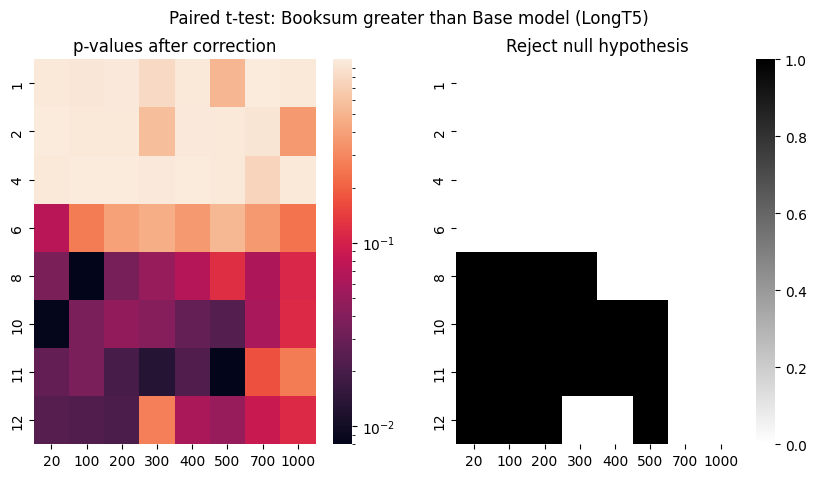

In [13]:
# ============== This cell contains code for: ========================
# === Figure 1 ===
# === Statistical significance – base vs booksum – 20vs20 accuracy ===
# === PART 2 ===

# BART, LED, BigBird, LongT5
p_value_20v20_bart = [0.019851429283594454, 0.7705694959661908, 0.40506982486139537, 0.8078960743690898, 0.15063041784902997, 0.08203067512901356, 0.0015249936071387168, 0.3528460312163625, 0.01617278887308322, 0.052772512644398896, 0.012997353432346353, 0.0012351175910106046, 0.0764626765590053, 0.15857247393927282, 0.004651964828437447, 0.00037749138432117914, 0.005630866438127436, 0.2156739523631208, 0.03402971918565796, 0.002873352530319265, 0.004158496200170388, 0.0099463654767167, 0.061314191699507595, 0.11531995673427263, 0.17818203709361247, 0.0003520380598260574, 0.005475982061015495, 0.0077763271292648, 0.010144453227454222, 0.048853410827838846, 0.11726284600700461, 0.009162828323484681, 0.03271283991654454, 0.03892464847334996, 0.0008042361692409564, 0.10904099162389055, 0.21394927667750652, 0.005368717612772551, 0.005712516918572965, 0.0072846112552726, 0.004450111159053547, 0.02616904415090374, 0.40272676752659203, 0.20241332947118457, 0.0005659121164829122, 0.06301302001044727, 0.32373024091300884, 0.04426558612664919]
p_value_20v20_led = [0.13840504379681307, 0.7156112112003212, 0.058171590516895064, 0.8466553147081266, 0.6301728632122238, 0.2679368134760132, 0.7076698422011631, 0.8820138704243214, 0.002711241129040634, 0.14111288277247705, 0.5537370756279891, 0.005243388995314616, 0.010304525034251851, 0.00870610798044041, 0.6460276993009537, 0.7668481722877173, 0.08474468639539055, 0.28785161716616137, 0.0007301041930596852, 0.00029875961595407914, 0.00016652089818165806, 0.0708300727284271, 0.6214927008679022, 0.5452928019244433, 0.024418035029216526, 0.005569955603073052, 0.0022382021511009416, 0.005631648271320726, 0.00014597116380732095, 0.07630238620824299, 0.6615103172717816, 0.7749827094080941, 0.05199791402614648, 0.007380922331086532, 0.02221328136527754, 0.0031037599959427547, 0.09768457849699695, 0.012647233420365436, 0.6544774798526058, 0.5958947414095321, 0.29437639744227867, 0.04792061034950434, 0.38820092404222317, 0.02859560802443155, 0.1707568593377687, 0.0414709202169016, 0.5492560126594767, 0.8954565170446676, 0.5041352092329826, 0.03257642258170078, 0.0815820460664133, 0.18547408321103417, 0.012930930439355889, 0.04931390906401526, 0.43189499549225885, 0.8273002309651799, 0.3946780442821049, 0.19882962565134676, 0.002289618793830336, 0.18555925795691716, 0.45968882802332617, 0.33834148384282026, 0.7159158864860083, 0.7456948278184854]
# p_value_20v20_bigbird = [0.19830157562796236, 0.062320762469228665, 0.8382029890793852, 0.47881400385881634, 0.057142025756383295, 0.13217684521096845, 0.6681676390131523, 0.19991469124593875, 0.16278403843539271, 0.7471382718302799, 0.9376659549786986, 0.9944089784188882, 0.0776440812256003, 0.5812474056207555, 0.795271002115802, 0.4145537192985302, 0.1042042783951292, 0.09273452163988813, 0.4719507373798459, 0.009208409061909952, 0.14386500182670864, 0.3996699118607292, 0.7481757062610883, 0.5532175542022407, 0.13140413703799195, 0.010587208692167805, 0.10100937804508932, 0.03010599880674893, 0.035399012713164035, 0.1151965634856012, 0.10480909734186446, 0.09767792940208021, 0.6519949497355761, 0.0020182396040003023, 0.0005628243745163012, 0.0053386402956466595, 0.0057457636270834885, 0.01600963834418267, 0.15693910182906742, 0.05729087250557442, 0.04428316036210574, 0.002444642491166007, 0.0004436881756584403, 0.0008260619298450779, 0.05112443375831213, 0.0009174761625427187, 0.06695101680343984, 0.015826577961768624, 0.00026794280621462264, 0.0025755759664970995, 0.0007452983166842536, 0.009175662522298018, 0.03690939415119628, 0.0054565510792820016, 0.07310066003068048, 0.04418031785211936, 0.0003073339355823109, 0.0019763493625295746, 0.0011403722169460032, 0.010630030212386657, 0.02466401700327553, 0.003889536631638933, 0.056877549585431605, 0.0563908269564242]
p_value_20v20_bigbird = [0.16278403843539271, 0.7471382718302799, 0.9376659549786986, 0.9944089784188882, 0.0776440812256003, 0.5812474056207555, 0.795271002115802, 0.4145537192985302, 0.13140413703799195, 0.010587208692167805, 0.10100937804508932, 0.03010599880674893, 0.035399012713164035, 0.1151965634856012, 0.10480909734186446, 0.09767792940208021, 0.04428316036210574, 0.002444642491166007, 0.0004436881756584403, 0.0008260619298450779, 0.05112443375831213, 0.0009174761625427187, 0.06695101680343984, 0.015826577961768624, 3.523632909707714e-05, 0.0015369348544346296, 0.018581921199564914, 0.015055364343957864, 0.020654607042630255, 0.007611573285908086, 0.01091286386929211, 0.00851912500365799, 0.030259277731532332, 0.05038065468394457, 0.503591437328274, 0.7715640839657665, 0.18772921306386686, 0.08786886303255666, 0.401121366705898, 0.45866695277601444, 0.00042163911522013326, 0.005745337347630656, 0.015453430580524846, 0.2873854276173873, 0.4445257574323358, 0.9992060445054733, 0.898229272231421, 0.9345953219339327, 0.036286492797269254, 0.112857862322873, 0.010235954982531619, 0.41356152737461155, 0.9666641023725145, 0.7436667981127907, 0.48490287906915386, 0.725045083673918, 0.8760615989918004, 0.8654115389947753, 0.946038143804328, 0.048146426293481016, 0.019904344235900744, 0.33948763384799197, 0.498916025625607, 0.6801790956680136]
p_value_20v20_long_t5 = [0.9017833985561853, 0.8286324795911156, 0.939512297058102, 0.6240667994821887, 0.880551536353902, 0.3486434052475754, 0.9690613356146632, 0.8958354455740191, 0.9949250697824845, 0.8977527959886766, 0.8553174495728058, 0.40221299207982286, 0.9214966822608402, 0.847765282358484, 0.7883720178337872, 0.22911678739639818, 0.8395313288951322, 0.9600408976820106, 0.953014363153775, 0.9287617248325971, 0.9799361939889291, 0.8584962469372088, 0.5744379129142227, 0.8530323698952348, 0.025347309563112916, 0.15413432107792074, 0.2578891445375825, 0.3086611406964175, 0.23519859224756123, 0.36048361064409895, 0.23551043014458406, 0.13347565208953732, 0.00808232136265273, 0.0001064278688028794, 0.0066172578048929245, 0.01393303565721274, 0.023224318078229174, 0.054787338237098165, 0.020922427999134612, 0.04472621954130373, 0.00020797534131620392, 0.007279971879200251, 0.013118680661543149, 0.009805767702521744, 0.003956334669469446, 0.0028971399478694036, 0.018221332015294946, 0.04978763716871639, 0.0037764916070073444, 0.007765984698096764, 0.0017341233829156581, 0.000873348301899792, 0.0023092603798903987, 9.007657048601671e-05, 0.08698104459461269, 0.1502593076849229, 0.003124864166051497, 0.002478124195407319, 0.0019127351985264189, 0.15991230397073114, 0.020121183920403768, 0.014302510067469092, 0.03238917113800481, 0.05015164850243969]

p_value_20v20_list = p_value_20v20_bart + p_value_20v20_led + p_value_20v20_bigbird + p_value_20v20_long_t5

reject, pvals_corrected, _, _ = multipletests(p_value_20v20_list, alpha=0.05, method='fdr_bh')

# Select which model to analyze
nlp_model = 'long-t5'

layer_list = [1, 2, 4, 6, 8, 10, 11, 12]
if nlp_model == 'bigbird':
    layer_list = [2, 6, 10, 14, 18, 24, 28, 32]
seq_len_list = [20, 100, 200, 300, 400, 500, 700, 1000]
n_seq_len = 8
if nlp_model == 'bart':
    n_start = 0
    n_end = 48
    seq_len_list = [20, 100, 200, 300, 400, 500]
elif nlp_model == 'led':
    n_start = 48
    n_end = 112
elif nlp_model == 'bigbird':
    n_start = 112
    n_end = 176
elif nlp_model == 'long-t5':
    n_start = 176
    n_end = 240
    
pvals_corrected_selected = pvals_corrected[n_start:n_end]
reject_selected = reject[n_start:n_end]
reject_selected = reject_selected.astype(int)

print('Before correction:', len([x for x in p_value_20v20_list[n_start:n_end] if x < 0.05]))
print('After correction:', len([x for x in pvals_corrected_selected if x < 0.05]))

reject_matrix = reject_selected.reshape((len(layer_list), len(seq_len_list)))
pvals_corrected_matrix = pvals_corrected_selected.reshape((len(layer_list), len(seq_len_list)))

fig, axes = plt.subplots(1,2, figsize=(10,5))
fig.suptitle(f'Paired t-test: Booksum greater than Base model (LongT5)')
axes[0].set_title('p-values after correction')
axes[1].set_title('Reject null hypothesis')
sns.heatmap(ax=axes[0],
            data=pvals_corrected_matrix,
            xticklabels=seq_len_list, yticklabels=layer_list,
            norm=LogNorm())

sns.heatmap(ax=axes[1],
            data=reject_matrix,
            xticklabels=seq_len_list, yticklabels=layer_list,
            cmap='binary')



In [ ]:
# # === PART 3 ===
# reject, pvals_corrected, _, _ = multipletests(p_value_matrix.flatten(), alpha=0.05, method='fdr_bh')

# reject = reject.astype(int)

# reject_matrix = reject.reshape((len(layer_list), len(seq_len_list)))
# pvals_corrected_matrix = pvals_corrected.reshape((len(layer_list), len(seq_len_list)))

# fig, axes = plt.subplots(1,2, figsize=(10,5))
# fig.suptitle(f'Significant booksum minus base for {nlp_model.upper()}')
# axes[0].set_title('p-values after correction')
# axes[1].set_title('Reject null hypothesis')
# sns.heatmap(ax=axes[0],
#             data=pvals_corrected_matrix,
#             xticklabels=seq_len_list, yticklabels=layer_list,
#             norm=LogNorm())

# sns.heatmap(ax=axes[1],
#             data=reject_matrix,
#             xticklabels=seq_len_list, yticklabels=layer_list,
#             cmap='binary', vmin=0, vmax=1)


Before correction: 50
After correction: 50


<AxesSubplot:title={'center':'Reject null hypothesis'}>

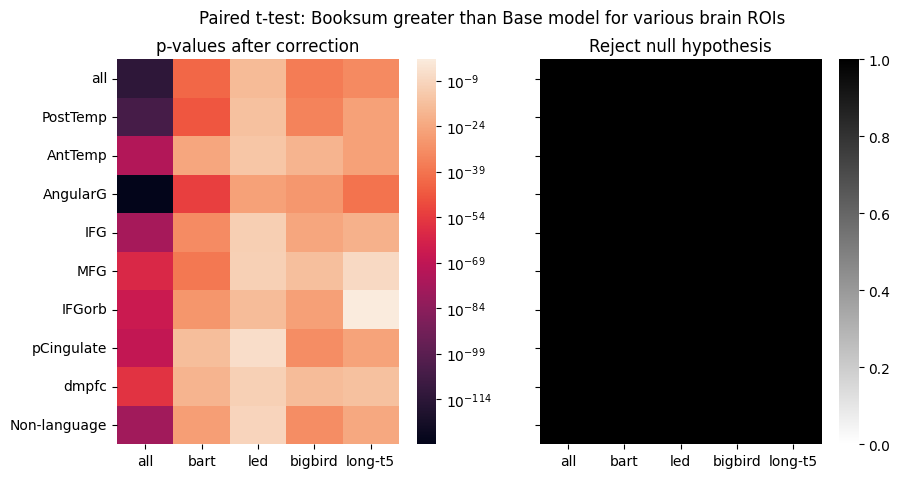

In [20]:
# ============== This cell contains code for: ========================
# === Figure 2, Right ===
# === Statistical significance – base vs booksum - for each brain ROI ===

roi_label_list = ['all', 'PostTemp', 'AntTemp', 'AngularG', 'IFG', 'MFG', 'IFGorb', 'pCingulate', 'dmpfc', 'Non-language']
p_value_roi_model_names = ['all', 'bart', 'led', 'bigbird', 'long-t5']

p_value_roi_list = []
p_value_roi_list += [3.357138940778886e-115, 2.1759042848784182e-107, 5.95416241937554e-75, 2.601006507218904e-131, 4.19883717949624e-78, 2.9415998022702636e-61, 3.854198554621772e-67, 1.0989134006562895e-69, 8.49745179177524e-58, 6.689564563997792e-80]
p_value_roi_list += [1.859404321499424e-43, 3.1283062300903164e-48, 2.6933558962097647e-25, 3.7659021595516826e-54, 9.149430317659871e-34, 6.2101815018475e-39, 9.6627136496807e-31, 4.317373205975338e-18, 6.166948437211953e-21, 6.017173711411907e-28]
p_value_roi_list += [9.41310771613642e-19, 7.041670134299029e-17, 1.7085344869151949e-15, 3.828841820436015e-27, 2.0678561607820556e-12, 1.2281137465402372e-11, 1.2796824465482824e-18, 1.9139609733535594e-07, 9.885496668436327e-12, 1.8929367933846497e-10]
p_value_roi_list += [4.944165292157259e-38, 3.3608377668855005e-36, 9.70711371615747e-21, 3.865774036392391e-30, 1.3908599883449267e-25, 2.924930638598193e-17, 1.5943207195529368e-27, 6.185960996708011e-33, 1.6258065252903415e-18, 8.368057318643404e-33]
p_value_roi_list += [3.19587589253849e-34, 8.145561674684463e-27, 5.426509378281711e-27, 1.6746365918776262e-40, 9.22010575285969e-22, 9.150622138690626e-09, 0.011627770638339543, 2.916212266024184e-26, 1.1759388107221205e-16, 3.70323184685014e-25]

reject, pvals_corrected, _, _ = multipletests(p_value_roi_list, alpha=0.05, method='fdr_bh')

pvals_corrected_matrix = np.array(pvals_corrected).reshape(5,10).transpose()
reject_matrix = np.array(reject).reshape(5,10).transpose()

print('Before correction:', len([x for x in p_value_roi_list if x < 0.05]))
print('After correction:', len([x for x in pvals_corrected if x < 0.05]))

fig, axes = plt.subplots(1,2, figsize=(10,5), sharey=True)
fig.suptitle(f'Paired t-test: Booksum greater than Base model for various brain ROIs')
axes[0].set_title('p-values after correction')
axes[1].set_title('Reject null hypothesis')
sns.heatmap(ax=axes[0],
            data=pvals_corrected_matrix,
            xticklabels=p_value_roi_model_names, yticklabels=roi_label_list,
            norm=LogNorm())

sns.heatmap(ax=axes[1],
            data=reject_matrix,
            xticklabels=p_value_roi_model_names, yticklabels=roi_label_list,
            cmap='binary', vmin=0, vmax=1)

Before correction: 14
After correction: 14


<AxesSubplot:title={'center':'Reject null hypothesis'}>

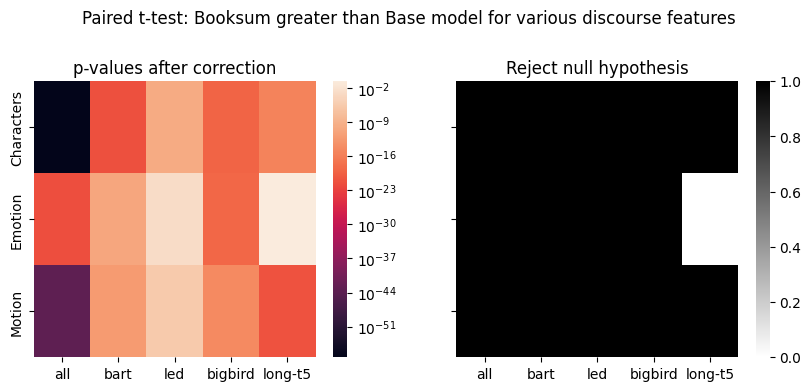

In [32]:
# ============== This cell contains code for: ========================
# === Figure 3b, Right ===
# === Statistical significance – base vs booksum - for each discourse feature ===

discourse_feature_list = ['Characters', 'Emotion', 'Motion', 'Non-discourse', 'Full']
p_value_model_names = ['all', 'bart', 'led', 'bigbird', 'long-t5']

# Layers 6 to 12
# p_value_discourse_list = []
# p_value_discourse_list += [1.589580957410081e-60, 3.919183789167221e-28, 9.400920555194934e-50, 1.0820692134633574e-25, 3.252990187585757e-22]
# p_value_discourse_list += [3.089478593645629e-17, 6.984675522927969e-07, 1.3879387770013187e-08, 1.931301648106231e-06, 1.0331387981380736e-05]
# p_value_discourse_list += [6.724382284334596e-09, 0.0008971281840332834, 8.99683406345985e-07, 0.04947521785451413, 0.0008365108111962647]
# p_value_discourse_list += [1.6764905846215595e-28, 1.865509859103432e-26, 4.589346872075758e-18, 5.7546632296805576e-15, 5.672436454265179e-10]
# p_value_discourse_list += [2.299399710082955e-16, 0.001484924637155727, 3.721988191049823e-30, 1.7633403140236095e-13, 9.802863881926462e-09]

# Layers 1 to 12
# p_value_discourse_list = []
# p_value_discourse_list += [3.129971193269186e-59, 5.365315263165712e-23, 4.205432387802319e-45, 5.245986953788277e-24, 1.4778366550942308e-18]
# p_value_discourse_list += [1.7628382906813157e-22, 2.0285215953713987e-11, 4.443630878955692e-13, 4.951163687163465e-09, 1.8870589459346321e-07]
# p_value_discourse_list += [8.523219646357165e-11, 0.001090135626055918, 2.9896945223893507e-06, 0.12262198082552087, 0.006347289095557193]
# p_value_discourse_list += [3.8443839127189954e-20, 9.157825752977463e-20, 1.9076513557159456e-15, 7.767172958116534e-13, 1.3567466489270657e-08]
# p_value_discourse_list += [3.447617911037758e-16, 0.290215359345456, 2.806972457819754e-22, 1.0137993226386827e-11, 3.7643068243115543e-06]

# Layers 1 to 12 -- Only Characters, Emotion, Motion
discourse_feature_list = ['Characters', 'Emotion', 'Motion']
p_value_discourse_list = []
p_value_discourse_list += [3.129971193269186e-59, 5.365315263165712e-23, 4.205432387802319e-45]
p_value_discourse_list += [1.7628382906813157e-22, 2.0285215953713987e-11, 4.443630878955692e-13]
p_value_discourse_list += [8.523219646357165e-11, 0.001090135626055918, 2.9896945223893507e-06]
p_value_discourse_list += [3.8443839127189954e-20, 9.157825752977463e-20, 1.9076513557159456e-15]
p_value_discourse_list += [3.447617911037758e-16, 0.290215359345456, 2.806972457819754e-22]

reject, pvals_corrected, _, _ = multipletests(p_value_discourse_list, alpha=0.05, method='fdr_bh')

pvals_corrected_matrix = np.array(pvals_corrected).reshape(5,3).transpose()
reject_matrix = np.array(reject).reshape(5,3).transpose()

print('Before correction:', len([x for x in p_value_discourse_list if x < 0.05]))
print('After correction:', len([x for x in pvals_corrected if x < 0.05]))

fig, axes = plt.subplots(1,2, figsize=(10,4), sharey=True)
fig.suptitle(f'Paired t-test: Booksum greater than Base model for various discourse features')
fig.subplots_adjust(top=0.8)
axes[0].set_title('p-values after correction')
axes[1].set_title('Reject null hypothesis')
sns.heatmap(ax=axes[0],
            data=pvals_corrected_matrix,
            xticklabels=p_value_model_names, yticklabels=discourse_feature_list,
            norm=LogNorm())

sns.heatmap(ax=axes[1],
            data=reject_matrix,
            xticklabels=p_value_model_names, yticklabels=discourse_feature_list,
            cmap='binary', vmin=0, vmax=1)

Before correction: 8
After correction: 8


<AxesSubplot:title={'center':'Reject null hypothesis'}>

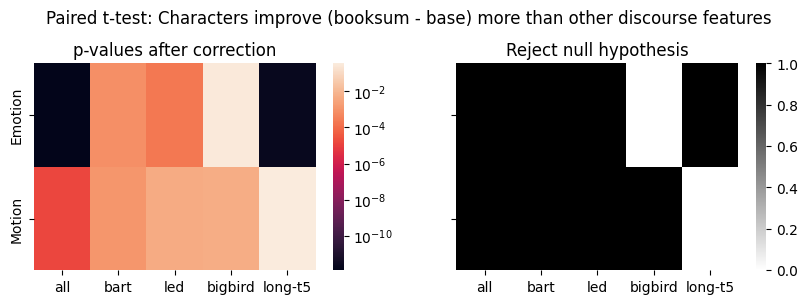

In [30]:
# ============== This cell contains code for: ========================
# === Figure 3b, Right (* but show that improvements for Character are greater than others)===
# === Statistical significance – booksum minus base - for each discourse feature ===

discourse_feature_list = ['Emotion', 'Motion', 'Non-discourse', 'Full']
p_value_model_names = ['all', 'bart', 'led', 'bigbird', 'long-t5']

# Layers 6 to 12
# p_value_characters_over_other_list = []
# p_value_characters_over_other_list += [5.178841464187343e-09, 0.0009972470173611212, 0.006190227354930784, 0.0017302501124728817]
# p_value_characters_over_other_list += [0.000458781790014043, 0.002334595935746028, 0.17879085328929556, 0.032365592252953435]
# p_value_characters_over_other_list += [0.002419923897159469, 0.08244940901237068, 0.0018005837072862926, 0.055250044191276]
# p_value_characters_over_other_list += [0.37015791922876873, 9.984698225127925e-05, 0.057263970371550746, 0.01878252609066071]
# p_value_characters_over_other_list += [1.6440915737732055e-07, 0.9294814305214552, 0.7250189387057913, 0.3536528704856422]

# Layers 1 to 12
# p_value_characters_over_other_list = []
# p_value_characters_over_other_list += [1.245823231378268e-13, 4.018805619146466e-06, 0.004844192829418054, 0.0001435464853155536]
# p_value_characters_over_other_list += [0.0003868316828374528, 0.000671671985929747, 0.2456649849595065, 0.03751517145589955]
# p_value_characters_over_other_list += [8.064993350937608e-05, 0.0030223810145947544, 5.171531223346712e-05, 0.0033619187392714234]
# p_value_characters_over_other_list += [0.2619840419135966, 0.0038222133899118876, 0.23203376024298927, 0.06216562737441828]
# p_value_characters_over_other_list += [4.577648585584656e-13, 0.3502699436137137, 0.6905993070108212, 0.11835272434575929]

# Layers 1 to 12 -- Only Characters, Emotion, Motion
discourse_feature_list = discourse_feature_list[:2]
p_value_characters_over_other_list = []
p_value_characters_over_other_list += [1.245823231378268e-13, 4.018805619146466e-06]
p_value_characters_over_other_list += [0.0003868316828374528, 0.000671671985929747]
p_value_characters_over_other_list += [8.064993350937608e-05, 0.0030223810145947544]
p_value_characters_over_other_list += [0.2619840419135966, 0.0038222133899118876]
p_value_characters_over_other_list += [4.577648585584656e-13, 0.3502699436137137]

reject, pvals_corrected, _, _ = multipletests(p_value_characters_over_other_list, alpha=0.05, method='fdr_bh')

pvals_corrected_matrix = np.array(pvals_corrected).reshape(5,2).transpose()
reject_matrix = np.array(reject).reshape(5,2).transpose()

print('Before correction:', len([x for x in p_value_characters_over_other_list if x < 0.05]))
print('After correction:', len([x for x in pvals_corrected if x < 0.05]))

fig, axes = plt.subplots(1,2, figsize=(10,3), sharey=True)
fig.suptitle(f'Paired t-test: Characters improve (booksum - base) more than other discourse features')
fig.subplots_adjust(top=0.8)
axes[0].set_title('p-values after correction')
axes[1].set_title('Reject null hypothesis')
sns.heatmap(ax=axes[0],
            data=pvals_corrected_matrix,
            xticklabels=p_value_model_names, yticklabels=discourse_feature_list,
            norm=LogNorm())

sns.heatmap(ax=axes[1],
            data=reject_matrix,
            xticklabels=p_value_model_names, yticklabels=discourse_feature_list,
            cmap='binary', vmin=0, vmax=1)

In [21]:
# ============== This cell contains code for: ========================
# === Figure 4 ===
# === PART 1: Multiple test correction of p-values that were already pre-computed and pickled ===

input_p_value_dir = '9-pearson-voxels-for-brain-plot/significant_voxel_indicator'
corrected_p_value_dir = '9-pearson-voxels-for-brain-plot/after_correction_p_values'

nlp_model_list = ['bart', 'led', 'bigbird', 'long-t5']
visualization_setting_list = ['booksum', 'booksum_minus_base/two-sided']
discourse_feature_list = ['Characters', 'Full']
subject_list = ['F', 'H', 'I', 'J', 'K', 'L', 'M', 'N']

n_voxels_tracking_list = []
overall_p_value_list = []
for nlp_model in nlp_model_list:
    for viz_setting in visualization_setting_list:
        for discourse_feature in discourse_feature_list:
            for subject in subject_list:
                input_p_value_pkl_path = os.path.join(input_p_value_dir, f'{nlp_model}/{viz_setting}/{discourse_feature}_{subject}.pkl')
                input_p_value_list = pickle.load( open(input_p_value_pkl_path, 'rb') )
                
                overall_p_value_list += input_p_value_list          # Add p-values
                n_voxels_tracking_list.append(len(input_p_value_list))   # Add number of p-values, used for splitting purposes later
                
print('overall_p_value_list:', len(overall_p_value_list))
print('before correction:', len([ x for x in overall_p_value_list if x < 0.05 ]))
reject, pvals_corrected, _, _ = multipletests(overall_p_value_list, alpha=0.05, method='fdr_bh')
print('after correction:', len([ x for x in pvals_corrected if x < 0.05 ]))

overall_p_value_list: 3370096
before correction: 1160985
after correction: 925291


In [22]:
tracking_count = -1
n_start = 0
n_end = 0
for nlp_model in nlp_model_list:
    for viz_setting in visualization_setting_list:
        for discourse_feature in discourse_feature_list:
            for subject in subject_list:
                tracking_count += 1                                 # Get the count number for the particular configuration
                n_voxels = n_voxels_tracking_list[tracking_count]   # Get the number of voxels
                n_start = n_end                                     # Get the starting voxel number
                n_end = n_start + n_voxels                          # Get the end voxel number
                
                corrected_p_value_list = pvals_corrected[n_start:n_end]
                
                corrected_p_value_pkl_path = os.path.join(corrected_p_value_dir, f'{nlp_model}/{viz_setting}/{discourse_feature}_{subject}.pkl')
                os.makedirs( os.path.dirname(corrected_p_value_pkl_path), exist_ok=True )
                with open(corrected_p_value_pkl_path, 'wb') as handle:
                    pickle.dump(corrected_p_value_list, handle, protocol=pickle.HIGHEST_PROTOCOL)
                

In [26]:
# Check that correction of voxel p-values was performed correctly
for nlp_model in nlp_model_list:
    for viz_setting in visualization_setting_list:
        for discourse_feature in discourse_feature_list:
            for subject in subject_list:
                input_p_value_pkl_path = os.path.join(input_p_value_dir, f'{nlp_model}/{viz_setting}/{discourse_feature}_{subject}.pkl')
                input_p_value_list = pickle.load( open(input_p_value_pkl_path, 'rb') )
                input_sig_voxels = np.array([(x < 0.05) for x in input_p_value_list])
                
                corrected_p_value_pkl_path = os.path.join(corrected_p_value_dir, f'{nlp_model}/{viz_setting}/{discourse_feature}_{subject}.pkl')
                corrected_p_value_list = pickle.load( open(corrected_p_value_pkl_path, 'rb') )
                corrected_sig_voxels = np.array([(x < 0.05) for x in corrected_p_value_list])
                
                assert(len(input_p_value_list) == len(corrected_p_value_list))  # Check they are same length at least
                assert(len([x for x in corrected_sig_voxels if x ]) <= len([x for x in input_sig_voxels if x ]))    # Check it is less voxels
                
                assert( np.array_equal( np.logical_or(input_sig_voxels, corrected_sig_voxels), input_sig_voxels) )
                assert( np.array_equal( np.logical_and(input_sig_voxels, corrected_sig_voxels), corrected_sig_voxels) )

In [32]:
# === Given Pearson values for brain voxels, only keep those where significant ===
all_voxels_dir = '9-pearson-voxels-for-brain-plot/voxel_values'
only_sig_voxels_dir = '9-pearson-voxels-for-brain-plot/only_significant'
sig_voxel_indicator_dir = f'9-pearson-voxels-for-brain-plot/after_correction_p_values'

for nlp_model in ['bart', 'led', 'bigbird', 'long-t5']:
    for ttest_alternative in ['two-sided']:
        for discourse_feature in ['Characters', 'Full']:
            
            output_dir = os.path.join(only_sig_voxels_dir, nlp_model, ttest_alternative, discourse_feature)
            os.makedirs(output_dir, exist_ok=True)
            
            for subject in ['F', 'H', 'I', 'J', 'K', 'L', 'M', 'N']:
                print(f'=== {nlp_model} {ttest_alternative}_{discourse_feature}_{subject}===')
                # Get Pearson values for all voxels
                all_voxels_pkl_path = os.path.join(all_voxels_dir, nlp_model, discourse_feature, f'pearson_voxels_{discourse_feature}_{subject}.pkl')
                all_voxels_dict = pickle.load(open(all_voxels_pkl_path, 'rb'))
                all_voxels_booksum_minus_base_pearson = all_voxels_dict['booksum_minus_base_pearson_voxels']    # list of ~27905
                all_voxels_booksum = all_voxels_dict['booksum_pearson_voxels']                                  # list of ~27905
                
                n_voxels = len(all_voxels_booksum)
                
                # Booksum minus Base -- identify which voxels are significant (already done earlier and saved in pickle)
                sig_voxel_indicator_list_pkl_path = os.path.join(sig_voxel_indicator_dir, nlp_model, 'booksum_minus_base', 
                                                                ttest_alternative, f'{discourse_feature}_{subject}.pkl')
                sig_voxel_indicator_list = pickle.load(open(sig_voxel_indicator_list_pkl_path, 'rb'))
                print('# sig voxels for booksum minus base:', len([x for x in sig_voxel_indicator_list if x < 0.05]))

                sig_voxels_booksum_minus_base_pearson = []
                for voxel_ind in range(n_voxels):
                    if sig_voxel_indicator_list[voxel_ind] < 0.05:
                        sig_voxels_booksum_minus_base_pearson.append(all_voxels_booksum_minus_base_pearson[voxel_ind])
                    else:
                        sig_voxels_booksum_minus_base_pearson.append(0)
                        
                # Booksum -- identify which voxels are significantly greater than 0 (already done earlier and saved in pickle)
                sig_voxel_indicator_list_pkl_path = os.path.join(sig_voxel_indicator_dir, nlp_model, 'booksum', 
                                                                f'{discourse_feature}_{subject}.pkl')
                sig_voxel_indicator_list = pickle.load(open(sig_voxel_indicator_list_pkl_path, 'rb'))
                print('# sig voxels for booksum:', len([x for x in sig_voxel_indicator_list if x < 0.05]))

                sig_voxels_booksum_pearson = []
                for voxel_ind in range(n_voxels):
                    if sig_voxel_indicator_list[voxel_ind] < 0.05:
                        sig_voxels_booksum_pearson.append(all_voxels_booksum[voxel_ind])
                    else:
                        sig_voxels_booksum_pearson.append(0)

                sig_voxels_dict = all_voxels_dict
                sig_voxels_dict['booksum_minus_base_pearson_voxels'] = sig_voxels_booksum_minus_base_pearson
                sig_voxels_dict['booksum_pearson_voxels'] = sig_voxels_booksum_pearson
                sig_voxels_pkl_path = os.path.join(output_dir, f'pearson_voxels_{discourse_feature}_{subject}.pkl')
                with open(sig_voxels_pkl_path, 'wb') as handle:
                    pickle.dump(sig_voxels_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

=== bart two-sided_Characters_F===
# sig voxels for booksum minus base: 3517
# sig voxels for booksum: 7185
=== bart two-sided_Characters_H===
# sig voxels for booksum minus base: 6401
# sig voxels for booksum: 9008
=== bart two-sided_Characters_I===
# sig voxels for booksum minus base: 8498
# sig voxels for booksum: 15119
=== bart two-sided_Characters_J===
# sig voxels for booksum minus base: 2789
# sig voxels for booksum: 12248
=== bart two-sided_Characters_K===
# sig voxels for booksum minus base: 7568
# sig voxels for booksum: 10265
=== bart two-sided_Characters_L===
# sig voxels for booksum minus base: 5625
# sig voxels for booksum: 8726
=== bart two-sided_Characters_M===
# sig voxels for booksum minus base: 5536
# sig voxels for booksum: 9538
=== bart two-sided_Characters_N===
# sig voxels for booksum minus base: 4239
# sig voxels for booksum: 9444
=== bart two-sided_Full_F===
# sig voxels for booksum minus base: 1825
# sig voxels for booksum: 3624
=== bart two-sided_Full_H===
# 

In [31]:
before_corrected_sig_booksum = []
before_corrected_sig_booksum_minus_base = []
before_corrected_dir = '9-pearson-voxels-for-brain-plot/significant_voxel_indicator'

after_corrected_sig_booksum = []
after_corrected_sig_booksum_minus_base = []
after_corrected_dir = '9-pearson-voxels-for-brain-plot/after_correction_p_values'

for nlp_model in ['bart', 'led', 'bigbird', 'long-t5']:
    for ttest_alternative in ['two-sided']:
        for discourse_feature in ['Characters', 'Full']:
            before_b_pkl_path = os.path.join(before_corrected_dir, nlp_model, 'booksum', f'{discourse_feature}_{subject}.pkl')
            before_b = pickle.load( open(before_b_pkl_path, 'rb') )
            before_corrected_sig_booksum.append( len([x for x in before_b if x < 0.05]) )
            
            before_bmb_pkl_path = os.path.join(before_corrected_dir, nlp_model, 'booksum_minus_base', ttest_alternative, f'{discourse_feature}_{subject}.pkl')
            before_bmb = pickle.load( open(before_bmb_pkl_path, 'rb') )
            before_corrected_sig_booksum_minus_base.append( len([x for x in before_bmb if x < 0.05]) )
            
            after_b_pkl_path = os.path.join(after_corrected_dir, nlp_model, 'booksum', f'{discourse_feature}_{subject}.pkl')
            after_b = pickle.load( open(after_b_pkl_path, 'rb') )
            after_corrected_sig_booksum.append( len([x for x in after_b if x < 0.05]) )
            
            after_bmb_pkl_path = os.path.join(after_corrected_dir, nlp_model, 'booksum_minus_base', ttest_alternative, f'{discourse_feature}_{subject}.pkl')
            after_bmb = pickle.load( open(after_bmb_pkl_path, 'rb') )
            after_corrected_sig_booksum_minus_base.append( len([x for x in after_bmb if x < 0.05]) )
            
print('=== Before correction ===')
print('Significant voxels for booksum:', sum(before_corrected_sig_booksum) / len(before_corrected_sig_booksum))
print('Significant voxels for booksum minus base:', sum(before_corrected_sig_booksum_minus_base) / len(before_corrected_sig_booksum_minus_base))
print('=== After correction ===')
print('Significant voxels for booksum:', sum(after_corrected_sig_booksum) / len(after_corrected_sig_booksum))
print('Significant voxels for booksum minus base:', sum(after_corrected_sig_booksum_minus_base) / len(after_corrected_sig_booksum_minus_base))

=== Before correction ===
Significant voxels for booksum: 9077.375
Significant voxels for booksum minus base: 7103.5
=== After correction ===
Significant voxels for booksum: 7848.625
Significant voxels for booksum minus base: 4704.5


In [8]:
# === NOT used ==> individually perform test correction for each configuration ===

# before_corrected_sum = 0
# after_corrected_sum = 0

# for nlp_model in nlp_model_list:
#     for viz_setting in visualization_setting_list:
#         for discourse_feature in discourse_feature_list:
#             for subject in subject_list:
#                 input_p_value_pkl_path = f'9-pearson-voxels-for-brain-plot/significant_voxel_indicator/{nlp_model}/{viz_setting}/{discourse_feature}_{subject}.pkl'
#                 input_p_value_list = pickle.load( open(input_p_value_pkl_path, 'rb') )
                
#                 before_corrected_sum += len([ x for x in input_p_value_list if x < 0.05 ])
#                 reject, pvals_corrected, _, _ = multipletests(input_p_value_list, alpha=0.05, method='fdr_bh')
#                 after_corrected_sum += len([ x for x in reject if x ])

# print('before_corrected_sum:', before_corrected_sum)
# print('after_corrected_sum:', after_corrected_sum)

before_corrected_sum: 1160985
after_corrected_sum: 891391
